The VGG() class takes a few arguments

1) include_top (True): Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.

2) weights (‘imagenet‘): What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.

3) input_tensor (None): A new input layer if you intend to fit the model on new data of a different size.

4) input_shape (None): The size of images that the model is expected to take if you change the input layer.

5) pooling (None): The type of pooling to use when you are training a new set of output layers.

6) classes (1000): The number of classes (e.g. size of output vector) for the model.

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
# from IPython.display import display, HTML

# import warnings
# warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16 as vgg
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils 
import np_utils

# import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [2]:
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 10
# 1e-4 = 0.0001
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [5]:
# This is one-hot encoding
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)
print(Y_train[:5])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [6]:
import cv2

X_train = np.array([cv2.resize(x, (32, 32)) for x in X_train])
X_val = np.array([cv2.resize(x, (32, 32)) for x in X_val])
X_test = np.array([cv2.resize(x, (32, 32)) for x in X_test])

**Prepare the Model**

Load VGG16 without the top classification layer

Prepare a custom classifier

Stack both models on top of each other

In [7]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [8]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [9]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

**Why do we freeze the layers ?**

Layer freezing means layer weights of a trained model are not changed when they are reused in a subsequent downstream task - they remain frozen. Essentially when backprop is done during training these layers weights are untouched.

link: https://www.quora.com/What-is-layer-freezing-in-transfer-learning

In [10]:
for layer in base_model.layers:
     layer.trainable = False

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

**Data Augmentation**

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [14]:
  train_datagen.fit(X_train)
  train_generator = train_datagen.flow(X_train,
                                      Y_train, 
                                      batch_size=BATCH_SIZE)

In [15]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,Y_val,batch_size=BATCH_SIZE)

**Train the Model**

In [16]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
664/664 [==============================] - 12s 19ms/step - loss: 1.7936 - accuracy: 0.3753 - val_loss: 1.2978 - val_accuracy: 0.5589
Epoch 2/50
664/664 [==============================] - 12s 18ms/step - loss: 1.3579 - accuracy: 0.5265 - val_loss: 1.1173 - val_accuracy: 0.6116
Epoch 3/50
664/664 [==============================] - 12s 18ms/step - loss: 1.2135 - accuracy: 0.5781 - val_loss: 1.0310 - val_accuracy: 0.6418
Epoch 4/50
664/664 [==============================] - 12s 18ms/step - loss: 1.1226 - accuracy: 0.6106 - val_loss: 0.9745 - val_accuracy: 0.6617
Epoch 5/50
664/664 [==============================] - 12s 18ms/step - loss: 1.0635 - accuracy: 0.6301 - val_loss: 0.9323 - val_accuracy: 0.6740
Epoch 6/50
664/664 [==============================] - 12s 18ms/step - loss: 1.0154 - accuracy: 0.6460 - val_loss: 0.8997 - val_accuracy: 0.6883
Epoch 7/50
664/664 [==============================] - 12s 18

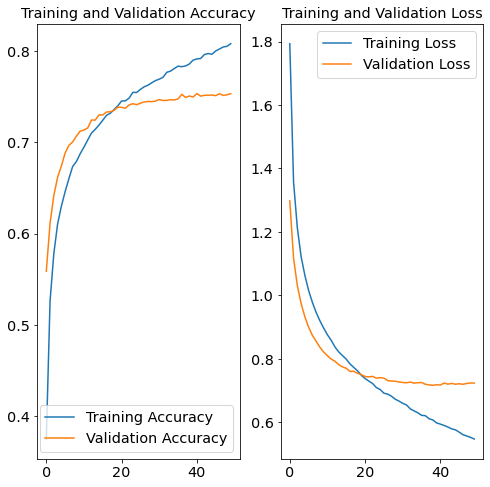

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [117]:
#Save the model
history.model.save("image_classification_TF.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: image_classification_TF.model/assets


In [83]:
STEP_SIZE_VAL=val_generator.n//val_generator.batch_size

loss_acc = model.evaluate_generator(generator=val_generator,steps=STEP_SIZE_VAL)

In [84]:
print("loss:",loss_acc[0],"\nAccuracy:",loss_acc[1])

loss: 0.7223419547080994 
Accuracy: 0.7532051205635071


In [108]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

test_datagen.fit(X_test)
test_generator = train_datagen.flow(X_test,
                                    Y_test,
                                    shuffle=False,
                                    batch_size=100)

In [109]:
STEP_SIZE_VAL=test_generator.n//test_generator.batch_size

loss_acc_test = model.evaluate_generator(generator=test_generator,steps=STEP_SIZE_VAL)
print("loss:",loss_acc_test[0],"\nAccuracy:",loss_acc_test[1])

loss: 0.7269835472106934 
Accuracy: 0.7508000135421753


In [110]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=0)

In [111]:
catagories = {'dog': 0,'automobile': 1,'bird': 2,'cat': 3,'deer': 4,'airplane': 5,'frog': 6,'horse': 7,'ship': 8,'truck': 9}
reverse_catagory = {n:i for i,n in catagories.items()}
print(reverse_catagory)

{0: 'dog', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'airplane', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [112]:
predicted_class_indices=np.argmax(pred,axis=1)
prediction = [reverse_catagory[img_] for img_ in predicted_class_indices]
print(prediction[:10],len(prediction))

['cat', 'automobile', 'ship', 'dog', 'frog', 'frog', 'automobile', 'bird', 'cat', 'frog'] 10000


In [113]:
actual = [reverse_catagory[img_[0]] for img_ in y_test]
print(actual[:10],len(actual))

['cat', 'ship', 'ship', 'dog', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile'] 10000


In [114]:
results=pd.DataFrame({"Actual":actual,
                     "Predictions":prediction})
results.head()

,Actual,Predictions
0,cat,cat
1,ship,automobile
2,ship,ship
3,dog,dog
4,frog,frog
